In [1]:
from scipy.signal import welch
import fastdyn_fic_dmf as dmf
import fastdmf as static_dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73

# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
data_folder = "/network/iss/cohen/data/Ivan/dyn_fic_dmf_simulations/Results"
figfold = "/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels"


In [2]:

def sim_run(G, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn

def sim_run_notplastic(G, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G: float, global coupling    
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates    

    """
    
    params = static_dmf.default_params(C=C)    
    params['G'] = G
    params['seed'] = SEED
    params['obj_rate'] = 3.44    
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1        
    rates_dyn = static_dmf.run(params, NB_STEPS,'rate')
    return rates_dyn

import numpy as np

def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr


def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

def get_avg_max_freq_and_power(rates_avg):
    freqs, psd = welch(rates_avg, fs=1000,axis=0,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:100])
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:100])
    return max_freqs, max_power,freqs,psd

## Generate control power distribution

In [3]:
import numpy as np
import os
from joblib import Parallel, delayed

LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 55000
G_VAL = 3.5
G_VAL_NOTPLASTIC = 2.1
SEED_BASE = 100

def run_simulation(idx, lr):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

def run_simulation_heterogeneous(idx, lr_hom, lr_het,het_regions_idx):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr_hom
    LR_VEC[het_regions_idx] = lr_het
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

def run_simulation_notplastic(idx):
    SEED = SEED_BASE + idx    
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates = sim_run_notplastic(G_VAL_NOTPLASTIC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

# Ensure the output directory exists
#os.makedirs("./Results/homogeneous", exist_ok=True)
#filename = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}.npy"
#np.save(filename, rates_all)
#print(f"Saved homogeneous simulation results for LR = {lr} to {filename}")

In [4]:
# Create a HIGH_LR homogeneous simaultion
HIGH_LR = 10000
NREPS = 100
G_VAL = 3.5
if os.path.exists(f"{data_folder}/homogeneous/g_{G_VAL}_lr_{HIGH_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"):
    print("Loading high lr")
    rates_all_high_lr = np.load(f"{data_folder}/homogeneous/g_{G_VAL}_lr_{HIGH_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy")
else:
    simulations = Parallel(n_jobs=64)(delayed(run_simulation)(idx, HIGH_LR) for idx in range(NREPS))
    rates_all_high_lr = np.array(simulations)
    save_path = f"{data_folder}/homogeneous/g_{G_VAL}_lr_{HIGH_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"
    np.save(save_path, rates_all_high_lr)
# Create a LOW_LR homogeneous simaultion
LOW_LR = 100
# If the file already exists, load it instead of running the simulation
if os.path.exists(f"{data_folder}/homogeneous/g_{G_VAL}_lr_{LOW_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"):
    print("Loading low lr")
    rates_all_low_lr = np.load(f"{data_folder}/homogeneous/g_{G_VAL}_lr_{LOW_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy")
else:
    simulations = Parallel(n_jobs=64)(delayed(run_simulation)(idx, LOW_LR) for idx in range(NREPS))
    rates_all_low_lr = np.array(simulations)
    save_path = f"{data_folder}/homogeneous/g_{G_VAL}_lr_{LOW_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"
    np.save(save_path, rates_all_low_lr)

# If not plastic file already exists, load it instead of running the simulation
#if os.path.exists(f"{data_folder}/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"):
#    print("Loading not plastic")
#    rates_all_notplastic = np.load(f"{data_folder}/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_{NREPS}reps_{NB_STEPS//1000}ksteps.npy")
#else:        
#    simulations_notplastic = Parallel(n_jobs=64)(delayed(run_simulation_notplastic)(idx) for idx in range(NREPS))
#    rates_all_notplastic = np.array(simulations_notplastic)
#    save_path = f"{data_folder}/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"
#    np.save(save_path, rates_all_notplastic)




Loading high lr
Loading low lr


In [5]:
from joblib import Parallel, delayed

# High LR
results_high_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_high_lr)
max_freqs_all_high_lr, max_powers_all_high_lr, freqs_all_high_lr, psd_all_high_lr = zip(*results_high_lr)
max_freqs_all_high_lr = np.array(max_freqs_all_high_lr)
max_powers_all_high_lr = np.array(max_powers_all_high_lr)
freqs_all_high_lr = np.array(freqs_all_high_lr)
psd_all_high_lr = np.array(psd_all_high_lr)

# Low LR
results_low_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_low_lr)
max_freqs_all_low_lr, max_powers_all_low_lr, freqs_all_low_lr, psd_all_low_lr = zip(*results_low_lr)
max_freqs_all_low_lr = np.array(max_freqs_all_low_lr)
max_powers_all_low_lr = np.array(max_powers_all_low_lr)
freqs_all_low_lr = np.array(freqs_all_low_lr)
psd_all_low_lr = np.array(psd_all_low_lr)

# Not plastic
#results_notplastic = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_notplastic)
#max_freqs_all_notplastic, max_powers_all_notplastic, freqs_all_notplastic, psd_all_notplastic = zip(*results_notplastic)
#max_freqs_all_notplastic = np.array(max_freqs_all_notplastic)
#max_powers_all_notplastic = np.array(max_powers_all_notplastic)
#freqs_all_notplastic = np.array(freqs_all_notplastic)
#psd_all_notplastic = np.array(psd_all_notplastic)


In [6]:
max_freqs_all_low_lr.shape

(100, 200)

In [5]:
rates_avg_reg_high_lr = np.mean(rates_all_high_lr, axis=1)
rates_avg_reg_low_lr = np.mean(rates_all_low_lr, axis=1)
#rates_avg_reg_notplastic = np.mean(rates_all_notplastic, axis=1)

In [12]:
# High LR
results_high_lr = Parallel(n_jobs=16)(delayed(get_avg_max_freq_and_power)(rates) for rates in rates_avg_reg_high_lr)
max_freqs_avg_high_lr, max_powers_avg_high_lr, freqs_all_high_lr, psd_all_high_lr = zip(*results_high_lr)
max_freqs_avg_high_lr = np.array(max_freqs_avg_high_lr)
max_powers_avg_high_lr = np.array(max_powers_avg_high_lr)
freqs_all_high_lr = np.array(freqs_all_high_lr)
psd_all_high_lr = np.array(psd_all_high_lr)

# Low LR
results_low_lr = Parallel(n_jobs=16)(delayed(get_avg_max_freq_and_power)(rates) for rates in rates_avg_reg_low_lr)
max_freqs_avg_low_lr, max_powers_avg_low_lr, freqs_all_low_lr, psd_all_low_lr = zip(*results_low_lr)
max_freqs_avg_low_lr = np.array(max_freqs_avg_low_lr)
max_powers_avg_low_lr = np.array(max_powers_avg_low_lr)
freqs_all_low_lr = np.array(freqs_all_low_lr)
psd_all_low_lr = np.array(psd_all_low_lr)

# Not plastic
#results_notplastic = Parallel(n_jobs=16)(delayed(get_avg_max_freq_and_power)(rates) for rates in rates_avg_reg_notplastic)
#max_freqs_avg_notplastic, max_powers_avg_notplastic, freqs_all_notplastic, psd_all_notplastic = zip(*results_notplastic)
#max_freqs_avg_notplastic = np.array(max_freqs_avg_notplastic)
#max_powers_avg_notplastic = np.array(max_powers_avg_notplastic)
#freqs_all_notplastic = np.array(freqs_all_notplastic)
#psd_all_notplastic = np.array(psd_all_notplastic)


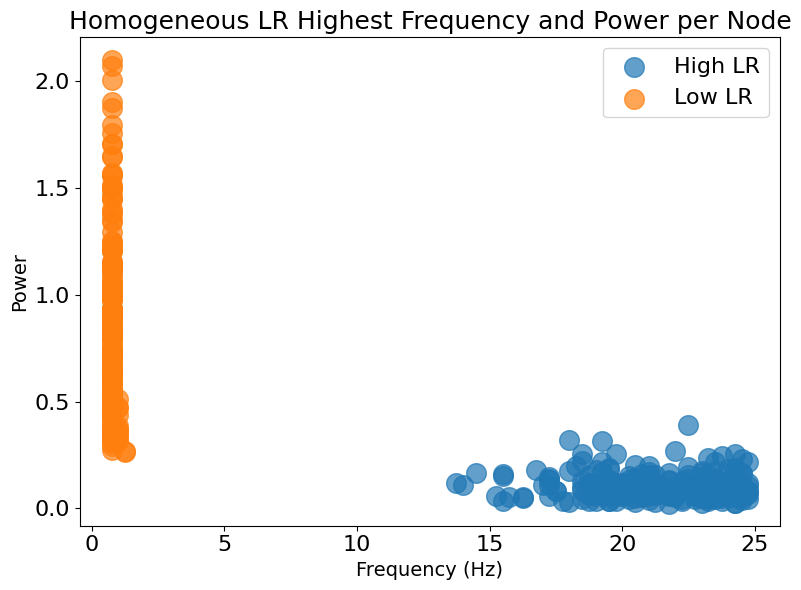

In [87]:
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 16
LEGEND = 16

# Parameters
figname = 'FIG_6_A'

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots for high and low learning rates
ax.scatter(max_freqs_all_high_lr[0, :], max_powers_all_high_lr[0, :], label="High LR", alpha=0.7,s=200)
ax.scatter(max_freqs_all_low_lr[0, :], max_powers_all_low_lr[0, :], label="Low LR", alpha=0.7,s=200)

# Labels, title, and legend
ax.set_xlabel("Frequency (Hz)", fontsize=LABEL)
ax.set_ylabel("Power", fontsize=LABEL)
ax.set_title("Homogeneous LR Highest Frequency and Power per Node", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(fontsize=LEGEND)

# Layout and save
plt.tight_layout()
fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)
plt.show()


In [ ]:
### Average of rates freq decomposition
plt.scatter(max_freqs_avg_high_lr[0], max_powers_avg_high_lr[0], label="High LR")
plt.scatter(max_freqs_avg_low_lr[0], max_powers_avg_low_lr[0], label="Low LR")
plt.scatter(max_freqs_avg_notplastic[0], max_powers_avg_notplastic[0], label="Not plastic")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Homogeneous LR Highest Frequency and Power per node")
plt.show()

## Sanity autocorrelation check

In [7]:
rates_all_low_lr[0].shape

(200, 50000)

In [ ]:
### Sanity check autocorrelation non plastic comparison
autocorr_low_lr_avg = get_autcorr(rates_all_low_lr[0,0])
autocorr_notplastic_avg = get_autcorr(rates_all_notplastic[0,0])
lags = np.arange(0,len(autocorr_low_lr_avg))
plt.plot(lags, autocorr_low_lr_avg,label='Low LR')
plt.plot(lags,autocorr_notplastic_avg,label='Not plastic')

plt.xlim([0,10000])
#plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

In [35]:

autocorr_low_lr_avg = get_autcorr(np.mean(rates_all_low_lr[0],axis=0))
autocorr_notplastic_avg = get_autcorr(np.mean(rates_all_notplastic[0],axis=0))


In [ ]:
lags = np.arange(0,len(autocorr_low_lr_avg))
plt.plot(lags, autocorr_low_lr_avg,label='Low LR')
plt.plot(lags,autocorr_notplastic_avg,label='Not plastic')

plt.xlim([0,10000])
#plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

In [86]:
figfold

'/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels'

## Quimera-watching

In [18]:
from bct import score_wu, rich_club_wu
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]

score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 

In [81]:
G_VAL = 3.5
LR_HOMO = 10000
LR_HET = 100
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]
if not os.path.exists(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}"):
    LR_HOMO_VEC = np.ones(200)*LR_HOMO
    MAX_LAGS = 500
    BURNOUT = 5000
    AUTOCORR_TMAX = 3000
    
    quimeric_delta = np.zeros((len(amount_of_regions),200))
    max_freqs_all_het = np.zeros((len(amount_of_regions),100,200))
    max_powers_all_het = np.zeros((len(amount_of_regions),100,200))
    for NTH_IDX,NTH in enumerate(amount_of_regions):
        print(f"Doing for {NTH} regions")
        SELECTED_REGIONS = most_connected[:NTH]
        LR_HET_VEC = LR_HOMO_VEC.copy()
        LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
        print("Simulating")
        simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
        rates_all_het = np.array(simulations)
        print("Calculating power")
        results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
        for idx, (max_freqs, max_powers, _, _) in enumerate(results):
            max_freqs_all_het[NTH_IDX,idx] = max_freqs
            max_powers_all_het[NTH_IDX,idx] = max_powers
        print("Crafting quimeric delta")    
        quimeric_delta[NTH_IDX] = 2 * (max_freqs_all_het[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

    G_VAL = 3.5
    LR_HOMO = 10000
    LR_HOMO_VEC = np.ones(200)*LR_HOMO
    LR_HET = 100
    MAX_LAGS = 500
    BURNOUT = 5000
    AUTOCORR_TMAX = 3000
   

    quimeric_delta_score = np.zeros((len(cherry_pick_scores_idx),200))
    max_freqs_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
    max_powers_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
    for NTH_IDX,NTH in enumerate(cherry_pick_scores_idx):
        print(f"Doing for {NTH} regions")
        SELECTED_REGIONS = score_idxs[NTH]
        LR_HET_VEC = LR_HOMO_VEC.copy()
        LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
        print("Simulating")
        simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
        rates_all_het = np.array(simulations)
        print("Calculating power")
        results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
        for idx, (max_freqs, max_powers, _, _) in enumerate(results):
            max_freqs_all_het_score[NTH_IDX,idx] = max_freqs
            max_powers_all_het_score[NTH_IDX,idx] = max_powers
        print("Crafting quimeric delta")    
        quimeric_delta_score[NTH_IDX] = 2 * (max_freqs_all_het_score[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

    os.mkdir(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}")
    # Save the results
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy", quimeric_delta)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy", quimeric_delta_score)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy", max_freqs_all_het)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy", max_freqs_all_het_score)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy", max_powers_all_het)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy", max_powers_all_het_score)
else:
    # Load the previously saved data
    print("Loading quimeric deltas")
    quimeric_delta = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy")
    quimeric_delta_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy")
    max_freqs_all_het = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy")
    max_freqs_all_het_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy")
    max_powers_all_het = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy")
    max_powers_all_het_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy")


Loading quimeric deltas


In [74]:
for idx,NREG in enumerate(amount_of_regions):
    quimeric_regions = (quimeric_delta[idx]>0.5).sum()
    print(f"Changed {NREG} regions and got {quimeric_regions} quimeric regions")

Changed 13 regions and got 13 quimeric regions
Changed 78 regions and got 78 quimeric regions
Changed 102 regions and got 102 quimeric regions
Changed 134 regions and got 134 quimeric regions
Changed 152 regions and got 152 quimeric regions
Changed 176 regions and got 176 quimeric regions
Changed 195 regions and got 195 quimeric regions


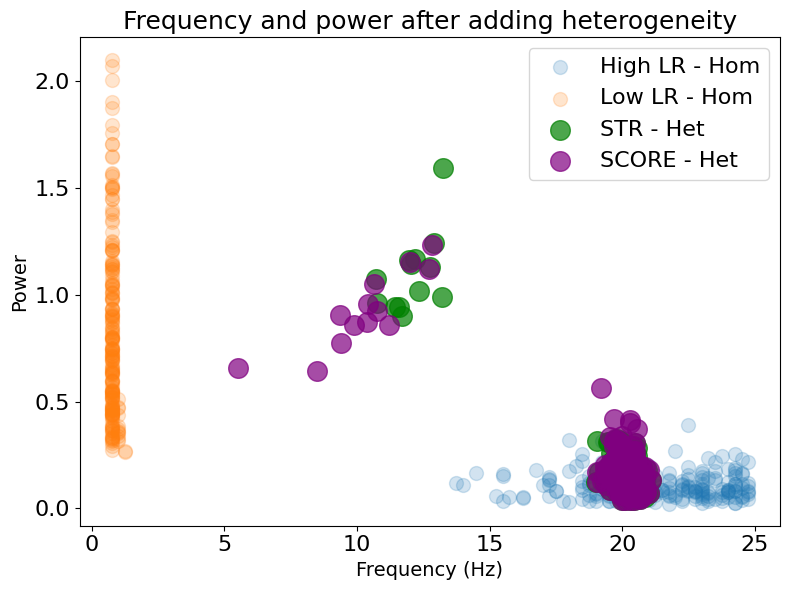

In [88]:
from turtle import color
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 16
LEGEND = 16

# Parameters
figname = 'FIG_6_B'

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots for high and low learning rates
ax.scatter(max_freqs_all_high_lr[0, :], max_powers_all_high_lr[0, :], label="High LR - Hom", alpha=0.2,s=100)
ax.scatter(max_freqs_all_low_lr[0, :], max_powers_all_low_lr[0, :], label="Low LR - Hom", alpha=0.2,s=100)
plt.scatter(max_freqs_all_het[0].mean(axis=0),max_powers_all_het[0].mean(axis=0),label="STR - Het",alpha=0.7,s=200,color='green')
plt.scatter(max_freqs_all_het_score[0].mean(axis=0),max_powers_all_het_score[0].mean(axis=0),label="SCORE - Het",alpha=0.7,s=200,color='purple')

# Labels, title, and legend
ax.set_xlabel("Frequency (Hz)", fontsize=LABEL)
ax.set_ylabel("Power", fontsize=LABEL)
ax.set_title("Frequency and power after adding heterogeneity", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(fontsize=LEGEND)

# Layout and save
plt.tight_layout()
fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)
plt.show()


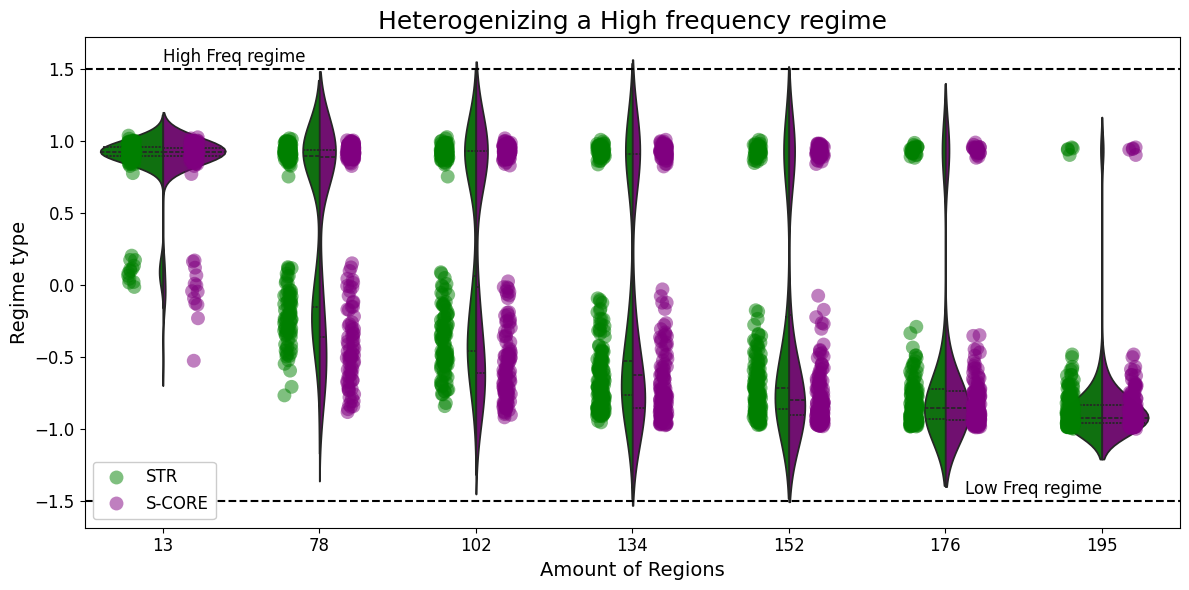

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname = 'FIG_6_C'

# Prepare a tidy DataFrame for plotting
data = pd.DataFrame({
    'value': np.concatenate([quimeric_delta.flatten(), quimeric_delta_score.flatten()]),
    'group': ['STR'] * quimeric_delta.size + ['S-CORE'] * quimeric_delta_score.size,
    'amount_of_regions': np.concatenate([np.repeat(amount_of_regions, 200), np.repeat(amount_of_regions, 200)])
})

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Strip plot
sns.stripplot(data=data, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, 
              palette=['green', 'purple'], s=10, alpha=0.5)
strip_handles, strip_labels = ax.get_legend_handles_labels()
sns.violinplot(data=data, x='amount_of_regions', y='value', hue='group', ax=ax, 
               palette=['green', 'purple'], split=True, inner='quartile')

# Add dashed line
ax.axhline(y=1.5, color='black', linestyle='--')
ax.text(0, 1.55, 'High Freq regime', color='black', fontsize=12, ha='left')

ax.axhline(y=-1.5, color='black', linestyle='--')
ax.text(6, -1.45, 'Low Freq regime', color='black', fontsize=12, ha='right')


# Labels, title, and legend
ax.set_xlabel("Amount of Regions", fontsize=LABEL)
ax.set_ylabel("Regime type", fontsize=LABEL)
ax.set_title("Heterogenizing a High frequency regime", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(strip_handles, strip_labels, fontsize=12, title_fontsize=14, loc='lower left',framealpha=1)

# Layout and save
plt.tight_layout()
fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)
plt.show()


In [90]:
G_VAL = 3.5
LR_HOMO = 100
LR_HET = 10000
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]
if not os.path.exists(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}"):
    LR_HOMO_VEC = np.ones(200)*LR_HOMO
    MAX_LAGS = 500
    BURNOUT = 5000
    AUTOCORR_TMAX = 3000
    
    quimeric_delta = np.zeros((len(amount_of_regions),200))
    max_freqs_all_het = np.zeros((len(amount_of_regions),100,200))
    max_powers_all_het = np.zeros((len(amount_of_regions),100,200))
    for NTH_IDX,NTH in enumerate(amount_of_regions):
        print(f"Doing for {NTH} regions")
        SELECTED_REGIONS = most_connected[:NTH]
        LR_HET_VEC = LR_HOMO_VEC.copy()
        LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
        print("Simulating")
        simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
        rates_all_het = np.array(simulations)
        print("Calculating power")
        results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
        for idx, (max_freqs, max_powers, _, _) in enumerate(results):
            max_freqs_all_het[NTH_IDX,idx] = max_freqs
            max_powers_all_het[NTH_IDX,idx] = max_powers
        print("Crafting quimeric delta")    
        quimeric_delta[NTH_IDX] = 2 * (max_freqs_all_het[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

    G_VAL = 3.5
    LR_HOMO = 10000
    LR_HOMO_VEC = np.ones(200)*LR_HOMO
    LR_HET = 100
    MAX_LAGS = 500
    BURNOUT = 5000
    AUTOCORR_TMAX = 3000
   

    quimeric_delta_score = np.zeros((len(cherry_pick_scores_idx),200))
    max_freqs_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
    max_powers_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
    for NTH_IDX,NTH in enumerate(cherry_pick_scores_idx):
        print(f"Doing for {NTH} regions")
        SELECTED_REGIONS = score_idxs[NTH]
        LR_HET_VEC = LR_HOMO_VEC.copy()
        LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
        print("Simulating")
        simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
        rates_all_het = np.array(simulations)
        print("Calculating power")
        results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
        for idx, (max_freqs, max_powers, _, _) in enumerate(results):
            max_freqs_all_het_score[NTH_IDX,idx] = max_freqs
            max_powers_all_het_score[NTH_IDX,idx] = max_powers
        print("Crafting quimeric delta")    
        quimeric_delta_score[NTH_IDX] = 2 * (max_freqs_all_het_score[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

    os.mkdir(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}")
    # Save the results
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy", quimeric_delta)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy", quimeric_delta_score)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy", max_freqs_all_het)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy", max_freqs_all_het_score)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy", max_powers_all_het)
    np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy", max_powers_all_het_score)
else:
    # Load the previously saved data
    print("Loading quimeric deltas")
    quimeric_delta = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy")
    quimeric_delta_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy")
    max_freqs_all_het = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy")
    max_freqs_all_het_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy")
    max_powers_all_het = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy")
    max_powers_all_het_score = np.load(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy")


Loading quimeric deltas


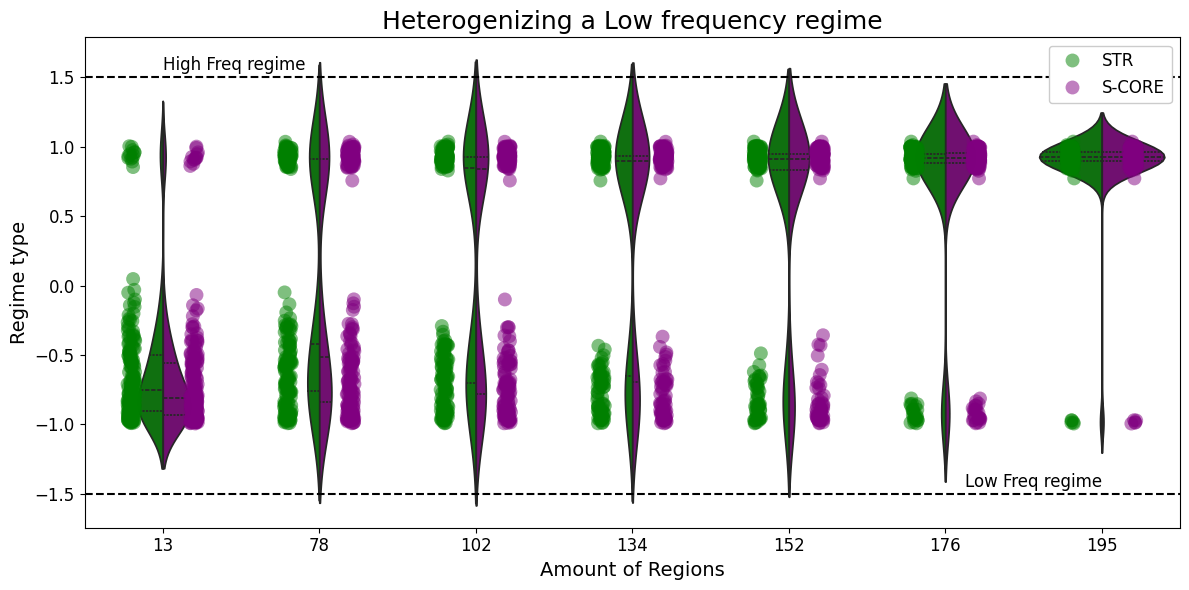

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname = 'FIG_6_D'

# Prepare a tidy DataFrame for plotting
data = pd.DataFrame({
    'value': np.concatenate([quimeric_delta.flatten(), quimeric_delta_score.flatten()]),
    'group': ['STR'] * quimeric_delta.size + ['S-CORE'] * quimeric_delta_score.size,
    'amount_of_regions': np.concatenate([np.repeat(amount_of_regions, 200), np.repeat(amount_of_regions, 200)])
})

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Strip plot
sns.stripplot(data=data, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, 
              palette=['green', 'purple'], s=10, alpha=0.5)
strip_handles, strip_labels = ax.get_legend_handles_labels()
sns.violinplot(data=data, x='amount_of_regions', y='value', hue='group', ax=ax, 
               palette=['green', 'purple'], split=True, inner='quartile')

# Add dashed line
ax.axhline(y=1.5, color='black', linestyle='--')
ax.text(0, 1.55, 'High Freq regime', color='black', fontsize=12, ha='left')

ax.axhline(y=-1.5, color='black', linestyle='--')
ax.text(6, -1.45, 'Low Freq regime', color='black', fontsize=12, ha='right')


# Labels, title, and legend
ax.set_xlabel("Amount of Regions", fontsize=LABEL)
ax.set_ylabel("Regime type", fontsize=LABEL)
ax.set_title("Heterogenizing a Low frequency regime", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(strip_handles, strip_labels, fontsize=12, title_fontsize=14, loc='upper right',framealpha=1)#, bbox_to_anchor=(0, 0.1))

# Layout and save
plt.tight_layout()
fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)
plt.show()
